In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import HamiltonianGate, UnitaryGate
import numpy as np
pi = np.pi

from qiskit.primitives import StatevectorEstimator
estimator_exact = StatevectorEstimator()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from circuit_functions import ki_circ_as_list, bm_circ_as_list, gates_list_to_qc, single_qubit_pauli_rotation_in_generic_form
from circuit_functions import two_qubit_pauli_rotation_in_generic_form, gates_list_to_transpiled_circuit, connected_qubits

In [2]:
coupling_map = np.load('calibration_data/coupling_map.npy')

# Set Parameters

In [3]:
num_qubits = 127

central_qubit = 62
device_qubits = [i for i in range(127)]

circuit_layers = [1,5,10,15,20]

Ls = np.load('calibration_data/layers.npy')
gate_layers = [[],[],[]]
for i in range(3):
    for q0, q1 in Ls[i]:
        if q0 in device_qubits and q1 in device_qubits:
            gate_layers[i].append([device_qubits.index(q0), device_qubits.index(q1)])

nearest_neighbour_layers = gate_layers

num_benchmarking_reps = 10
observable = 'I'*device_qubits.index(62) + 'Z' + 'I'*(num_qubits-device_qubits.index(62)-1)
observable = observable[::-1]

qubits_to_correct = [device_qubits.index(62)]

# Circuit generation

In [4]:
ki_circs_list = []
for i in range(5):
    ki_gates_list = ki_circ_as_list(num_qubits, circuit_layers[i], nearest_neighbour_layers, 0.01, 0.01, qubits_to_correct)
    ki_trans = gates_list_to_transpiled_circuit(ki_gates_list, num_qubits)
    ki_circs_list.append(ki_trans)
    clear_output(wait=True)
    print(i)
clear_output(wait=True)
print('Done!')

Done!


In [5]:
# bm_circs_list = [[],[],[],[],[]]
# for i in range(5):
#     for j in range(10):
#         bm_gates_list = bm_circ_as_list(num_qubits, circuit_layers[i], nearest_neighbour_layers, qubits_to_correct)
#         bm_trans = gates_list_to_transpiled_circuit(bm_gates_list, num_qubits)
#         bm_circs_list[i].append(bm_trans)

#         clear_output(wait=True)
#         print(i,j)
# clear_output(wait=True)
print('Done!')

Done!


# Our benchmarking on hardware

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2

# service = QiskitRuntimeService(
#     channel='ibm_quantum',
#     instance='ibm-q/open/main',
#     token='2244d1f24dc8f5b27f57655a4b1123a4c3ecf9e9aafc9bd8f113ff689edd40331bef9d24577ead8edd71035ab0da782bf52c3c374cb72e905badcfc5fc667c26'
# )

service = QiskitRuntimeService(name='personal')

hardware = service.backend('ibm_brisbane')

In [7]:
observable_trans = 'I'*62 + 'Z' + 'I'*(127-62-1)
observable_trans = observable_trans[::-1]

In [8]:
ki_circs_list_trans = []
for qc in ki_circs_list:
    qc_trans = transpile(qc, hardware, initial_layout=device_qubits, optimization_level=0)
    ki_circs_list_trans.append(qc_trans)

In [9]:
bm_circs_list_trans = []
for i in range(5):
    for j in range(10):
        qc = bm_circs_list[i][j]
        qc_trans = transpile(qc, hardware, initial_layout=device_qubits, optimization_level=0)
        bm_circs_list_trans.append(qc_trans)

        clear_output(wait=True)
        print(i,j)

In [10]:
circs_to_submit = ki_circs_list_trans + bm_circs_list_trans

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=0, backend=hardware)
circs_to_submit = [pm.run(qc) for qc in circs_to_submit]

estimator_hardware = EstimatorV2(mode=hardware)
job = estimator_hardware.run([(qc, observable_trans) for qc in circs_to_submit])
print(job.job_id())

In [12]:
# Fetch job results and save them

result = job.result()
hardware_noisy_vals = [abs(float(x.data.evs)) for x in result] 
np.save('127q.npy', hardware_noisy_vals)

In [13]:
hardware_noisy_vals = list(np.load('job_data/127q.npy'))

In [14]:
bm_hardware_noisy_vals = [hardware_noisy_vals[i*num_benchmarking_reps:(i+1)*num_benchmarking_reps] for i in range(len(circuit_layers))]
bm_hardware_fidelities = [np.mean(x) for x in bm_hardware_noisy_vals]
bm_hardware_stds = [np.std(x) for x in bm_hardware_noisy_vals]
bm_yerr = [bm_hardware_stds, bm_hardware_stds]

In [15]:
print('Benchmarking fidelities:', bm_hardware_fidelities)

Benchmarking fidelities: [0.8944330949948928, 0.5060776302349336, 0.2823799795709908, 0.1754341164453524, 0.1284984678243105]


# RB prediction using hardware data

In [16]:
ki_circs_list_rb = []
circuit_layers_rb = [1,2,3,4,5,10,15,20]
for i in range(8):
    if circuit_layers_rb[i] in circuit_layers:
        ki_circs_list_rb.append(ki_circs_list[circuit_layers.index(circuit_layers_rb[i])])
    else:
        ki_gates_list = ki_circ_as_list(num_qubits, circuit_layers_rb[i], nearest_neighbour_layers, 0.01, 0.01, qubits_to_correct)
        ki_trans = gates_list_to_transpiled_circuit(ki_gates_list, num_qubits)
        ki_circs_list_rb.append(ki_trans)
    clear_output(wait=True)
    print(i)
clear_output(wait=True)
print('Done!')

Done!


In [17]:
from rb_prediction import estimate_rb_fidelity
filename = 'calibration_data/ibm_brisbane_calibrations_2025-01-30T09_58_43Z.csv'
rb_fidelities = [estimate_rb_fidelity(qc, filename, device_qubits, measured_qubits=[device_qubits.index(62)]) for qc in ki_circs_list_rb]
print('Fidelities from RB:', rb_fidelities)

Fidelities from RB: [0.8889850801378854, 0.6150779684111403, 0.2667415648491814, 0.04733160820038014, 0.0017138411203079006, 1.678629363685418e-13, 9.11265813196265e-24, 4.946925153728375e-34]


# Plot results

C:\Users\joeh1\AppData\Local\Temp\ipykernel_11116\3235875217.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-x" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(circuit_layers_rb, rb_fidelities, '-x', linestyle='--', color='tab:green', label='Prediction from RB gate error data');


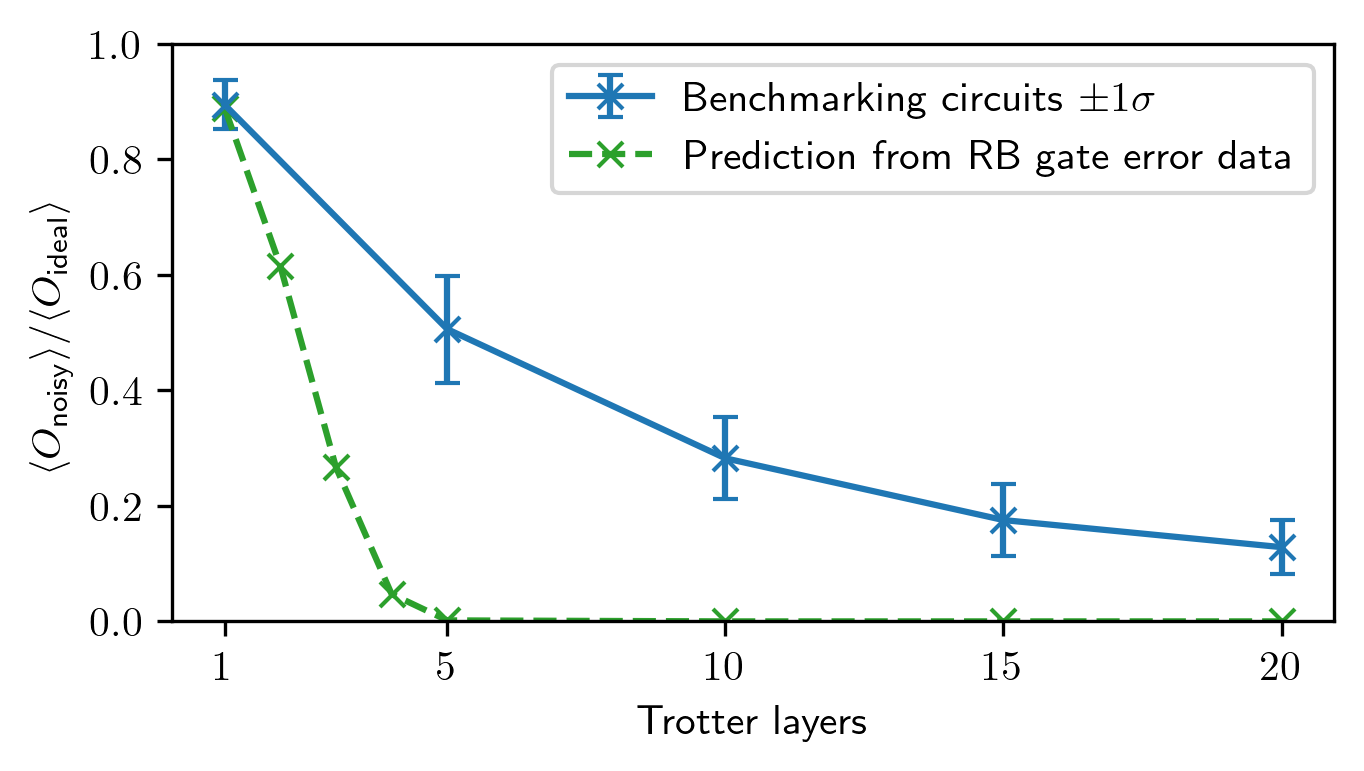

In [18]:
plt.figure(dpi=300, figsize=(5,2.5))
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'

plt.errorbar(circuit_layers, bm_hardware_fidelities, yerr=bm_yerr, marker='x', color='tab:blue', capsize=3, label=r'Benchmarking circuits $\pm 1\sigma$')
plt.plot(circuit_layers_rb, rb_fidelities, '-x', linestyle='--', color='tab:green', label='Prediction from RB gate error data');

plt.xlabel('Trotter layers')
plt.ylabel(r'$ \langle O_\text{noisy} \rangle / \langle O_\text{ideal} \rangle$')


handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.ylim([0,1])

plt.xticks([1,5,10,15,20])

plt.savefig('127-qubit-benchmarking.pdf', bbox_inches='tight')
plt.show()